## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

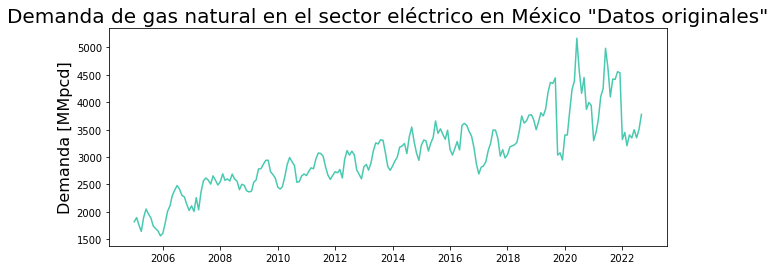

In [3]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

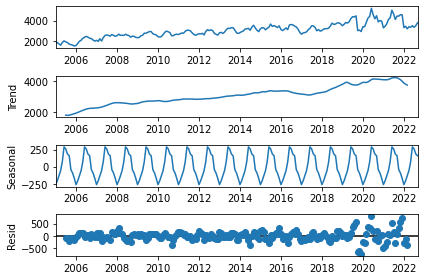

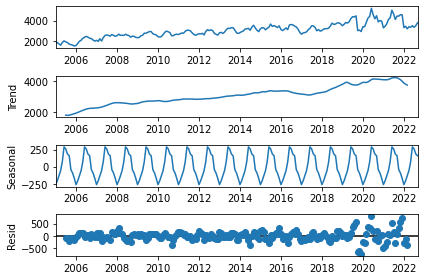

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [5]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [8]:
n_input = 36

# Assuming you have a column in your DataFrame named 'demand_data' that contains your time series data
data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values
targets = data  # You can adjust this if your target data is different

demanda_electrico_NOscaled_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

# Access the first batch of data
batch_x, batch_y = next(iter(demanda_electrico_NOscaled_train_generator))


In [9]:
demanda_electrico_NOscaled_train_generator[1]

(array([[1895.33, 1765.86, 1642.7 , 1895.54, 2051.72, 1962.05, 1889.66,
         1739.1 , 1695.92, 1648.95, 1560.98, 1610.45, 1806.33, 2006.88,
         2108.31, 2298.9 , 2398.88, 2480.62, 2413.08, 2298.49, 2273.91,
         2134.41, 2025.98, 2108.85, 2006.81, 2259.02, 2036.62, 2361.78,
         2567.22, 2618.43, 2579.35, 2506.83, 2657.24, 2577.97, 2489.39,
         2548.33]]),
 array([2694.39]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [10]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_original_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_NOscaled_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  165


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


Note: By setting input_shape=(n_input, n_features) in the first Dense layer, you're correctly specifying that each input sample will have a shape of (24, 1), which matches the shape of the data generated by your TimeseriesGenerator.

In [12]:
n_input = 36
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [13]:
model_sequential_and_FF.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36, 64)            128       
                                                                 
 dense_1 (Dense)             (None, 36, 32)            2080      
                                                                 
 dense_2 (Dense)             (None, 36, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [14]:
model_sequential_and_FF.fit(demanda_electrico_NOscaled_train_generator, epochs=25)

Epoch 1/25
165/165 [==============================] - 2s 2ms/step - loss: 2569248.7500
Epoch 2/25
165/165 [==============================] - 0s 2ms/step - loss: 198400.1250
Epoch 3/25
165/165 [==============================] - 0s 3ms/step - loss: 199693.2969
Epoch 4/25
165/165 [==============================] - 0s 2ms/step - loss: 199330.3438
Epoch 5/25
165/165 [==============================] - 0s 2ms/step - loss: 196657.9688
Epoch 6/25
165/165 [==============================] - 0s 3ms/step - loss: 201237.4531
Epoch 7/25
165/165 [==============================] - 0s 2ms/step - loss: 207671.9531
Epoch 8/25
165/165 [==============================] - 0s 2ms/step - loss: 204697.5938
Epoch 9/25
165/165 [==============================] - 0s 3ms/step - loss: 195021.3438
Epoch 10/25
165/165 [==============================] - 0s 2ms/step - loss: 203893.7031
Epoch 11/25
165/165 [==============================] - 0s 2ms/step - loss: 204728.4062
Epoch 12/25
165/165 [==============================

Se grafica la perdida por epoch 

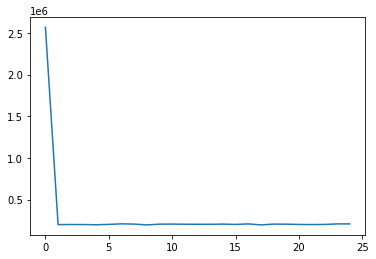

In [15]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [16]:

data = csv_demanda_electrico_original_train_data['Demanded_Gas'].values

demanda_electrico_NOscaled_train_batch = data[-n_input:]


demanda_electrico_NOscaled_train_batch

array([3765.69, 3772.25, 3676.41, 3500.08, 3647.6 , 3807.71, 3750.5 ,
       3876.48, 4184.76, 4361.97, 4343.61, 4445.27, 3037.44, 3076.62,
       2947.09, 3402.47, 3402.47, 3819.3 , 4235.25, 4387.91, 5168.27,
       4581.99, 4163.77, 4451.61, 3869.77, 3996.14, 3941.12, 3298.43,
       3454.21, 3681.3 , 4104.82, 4243.93, 4985.53, 4631.85, 4098.81,
       4424.39])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [17]:
demanda_electrico_NOscaled_train_batch_reshaped = demanda_electrico_NOscaled_train_batch.reshape(1,n_input, n_features)
demanda_electrico_NOscaled_train_batch_reshaped

array([[[3765.69],
        [3772.25],
        [3676.41],
        [3500.08],
        [3647.6 ],
        [3807.71],
        [3750.5 ],
        [3876.48],
        [4184.76],
        [4361.97],
        [4343.61],
        [4445.27],
        [3037.44],
        [3076.62],
        [2947.09],
        [3402.47],
        [3402.47],
        [3819.3 ],
        [4235.25],
        [4387.91],
        [5168.27],
        [4581.99],
        [4163.77],
        [4451.61],
        [3869.77],
        [3996.14],
        [3941.12],
        [3298.43],
        [3454.21],
        [3681.3 ],
        [4104.82],
        [4243.93],
        [4985.53],
        [4631.85],
        [4098.81],
        [4424.39]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [30]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)

1/1 [==============================] - 0s 70ms/step


array([[[4159.9077],
        [4167.1494],
        [4061.3474],
        [3866.688 ],
        [4029.5427],
        [4206.2954],
        [4143.139 ],
        [4282.2144],
        [4622.5396],
        [4818.171 ],
        [4797.902 ],
        [4910.13  ],
        [3355.9568],
        [3399.2097],
        [3256.215 ],
        [3758.9314],
        [3758.9314],
        [4219.091 ],
        [4678.2783],
        [4846.8076],
        [5708.2847],
        [5061.062 ],
        [4599.368 ],
        [4917.1284],
        [4274.807 ],
        [4414.313 ],
        [4353.5737],
        [3644.0767],
        [3816.0496],
        [4066.7463],
        [4534.29  ],
        [4687.8604],
        [5506.5493],
        [5116.105 ],
        [4527.6553],
        [4887.0796]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [19]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][-1][0]

1/1 [==============================] - 0s 23ms/step


4887.0796

In [ ]:
test_predictions_model_sequential_and_FF = []

In [37]:
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][0][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][1][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][2][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][3][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][4][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][5][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][6][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][7][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][8][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][9][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][10][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][11][0],
model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][12][0]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 53ms/step


4167.1494

In [38]:
test_predictions_model_sequential_and_FF = []

for i in range(12):
    prediction = model_sequential_and_FF.predict(demanda_electrico_NOscaled_train_batch_reshaped)[0][i][0]
    test_predictions_model_sequential_and_FF.append(prediction)

# Now, test_predictions_model_sequential_and_FF contains your 12 elements

1/1 [==============================] - 0s 26ms/step


In [39]:
test_predictions_model_sequential_and_FF 

[4159.9077,
 4167.1494,
 4061.3474,
 3866.688,
 4029.5427,
 4206.2954,
 4143.139,
 4282.2144,
 4622.5396,
 4818.171,
 4797.902,
 4910.13]

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos (ESCALADOS) de test de la demanda de gasd natural en sector eléctrico  

In [20]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values[0]

4417.51

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo 

In [21]:
n_input = 36
n_features = 1

In [22]:
test_predictions_model_sequential_and_FF = []

first_eval_batch = csv_demanda_electrico_original_train_data['Demanded_Gas'].values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_sequential_and_FF.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_sequential_and_FF.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain the 3D shape
    


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


In [23]:
test_predictions_model_sequential_and_FF

[4887.0796,
 5397.865,
 5961.7466,
 6584.2437,
 7271.4487,
 8030.088,
 8867.587,
 9792.1455,
 10812.811,
 11939.573,
 13183.462,
 14556.653]

In [24]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[ 4887.0796],
       [ 5397.865 ],
       [ 5961.7466],
       [ 6584.2437],
       [ 7271.4487],
       [ 8030.088 ],
       [ 8867.587 ],
       [ 9792.1455],
       [10812.811 ],
       [11939.573 ],
       [13183.462 ],
       [14556.653 ]], dtype=float32)

In [26]:
test_predictions_model_sequential_and_FF_2d

array([[ 4887.0796],
       [ 5397.865 ],
       [ 5961.7466],
       [ 6584.2437],
       [ 7271.4487],
       [ 8030.088 ],
       [ 8867.587 ],
       [ 9792.1455],
       [10812.811 ],
       [11939.573 ],
       [13183.462 ],
       [14556.653 ]], dtype=float32)

In [27]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

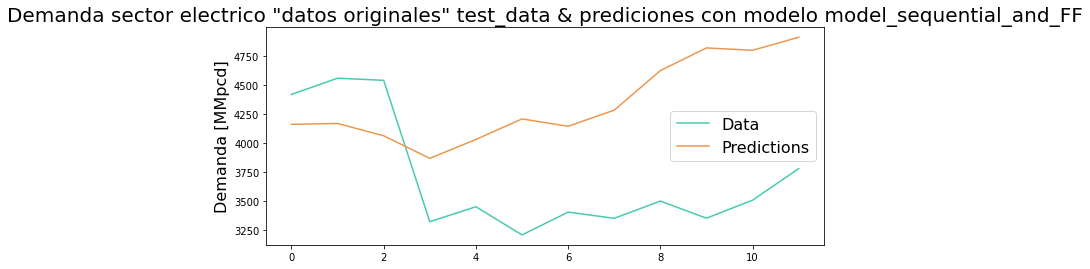

In [40]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [41]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF )
RMSE_predictions_model_sequential_and_FF = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF ))

print('MAPE:', MAPE_predictions_model_sequential_and_FF)
print('RMSE:', RMSE_predictions_model_sequential_and_FF)

MAPE: 0.2346442388830964
RMSE: 906.4635259008979
